# Technology focus: Xenium

This notebook will present an overview of the plotting functionalities of the `spatialdata` framework, in the context of a Xenium dataset.

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

## Loading the data

A reader for Xenium data is available in `spatialdata-io`. We used it to parse and convert to Zarr a [Xenium dataset of Human Lung Cancer](https://www.10xgenomics.com/datasets/preview-data-ffpe-human-lung-cancer-with-xenium-multimodal-cell-segmentation-1-standard).

You can download the data from the link above, or from this [convenience python script](https://github.com/giovp/spatialdata-sandbox/blob/main/xenium_2.0.0_io/download.py) and convert it to spatialdata format with [this script](https://github.com/giovp/spatialdata-sandbox/blob/main/xenium_2.0.0_io/to_zarr.py), rename the `.zarr` store to `xenium.zarr` and place it in the current folder (in alternatively you can use symlinks to make the data visible).

In [2]:
xenium_path = "./xenium.zarr"

A note on data loading. The data requires ~7 seconds to load because, while we support lazy representation of images, labels and points, the shapes geometries and the annotation tables are currently not represented lazily. This is one of the first spatial omics datasets which reaches a scale for which this is required. We will make a new release to allow for lazy representation also of these data types.

In [3]:
%%time
import spatialdata as sd

sdata = sd.read_zarr(xenium_path)
sdata

/Users/giovanni.palla/miniconda3/envs/sdata310/lib/python3.10/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/giovanni.palla/Projects/spatialdata/src/spatialdata/__init__.py:11: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
/Users/giovanni.palla/miniconda3/envs/sdata310/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
/Users/giovanni.palla/miniconda3/envs/sdata310/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.

CPU times: user 5.65 s, sys: 746 ms, total: 6.4 s
Wall time: 4.38 s


SpatialData object with:
├── Images
│     ├── 'he_image': MultiscaleSpatialImage[cyx] (3, 45087, 11580), (3, 22543, 5790), (3, 11271, 2895), (3, 5635, 1447), (3, 2817, 723)
│     └── 'morphology_focus': MultiscaleSpatialImage[cyx] (5, 17098, 51187), (5, 8549, 25593), (5, 4274, 12796), (5, 2137, 6398), (5, 1068, 3199)
├── Labels
│     ├── 'cell_labels': MultiscaleSpatialImage[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
│     └── 'nucleus_labels': MultiscaleSpatialImage[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
├── Points
│     └── 'transcripts': DataFrame with shape: (12165021, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (162254, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (162254, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (156628, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (162254, 377)
with coordinate systems:
▸ 'global', with elements

The datasets contains 2 large microscopy image, represented as a multiscale, chunked image; the first one, `he_image` is the H&E image of the tissue, stained post-Xenium measurement, and the `morphology_focus` image which consists of the image of the tissue used for the Xenium experiment.

Furthermore, it also contains label images, that are the segmentation masks of cells or nuclei (`cell_labels` and `nucleus_labels` respectively).

In [3]:
# # let's make the var names unique, this improves performance in accessing the tabular data
# for table in sdata.tables.values():
#     table.var_names_make_unique()

## Plotting the images

Let's visualize the images.

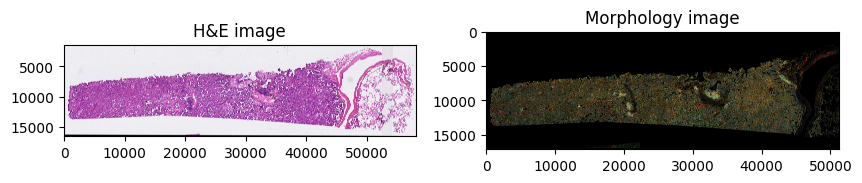

In [5]:
import matplotlib.pyplot as plt
import spatialdata_plot

axes = plt.subplots(1, 2, figsize=(10, 10))[1].flatten()
sdata.pl.render_images("he_image").pl.show(ax=axes[0], title="H&E image")
sdata.pl.render_images("morphology_focus").pl.show(ax=axes[1], title="Morphology image")

We can also crop and visualize a smaller region to appreciate morphological differences measured by the two modalities, together with the cell segmentation mask.

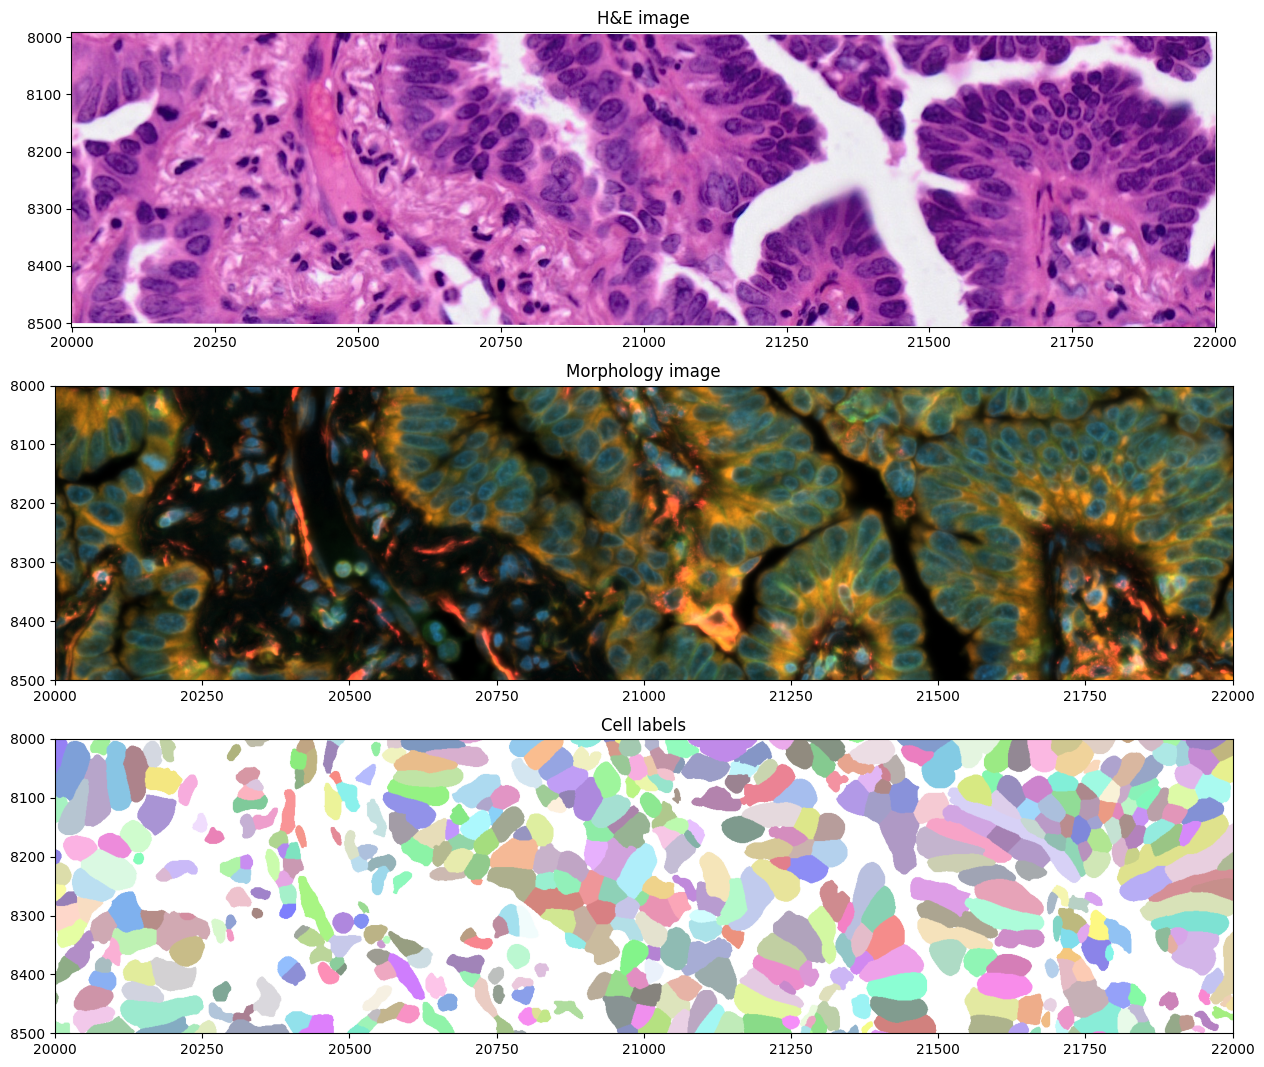

In [10]:
from spatialdata import bounding_box_query

axes = plt.subplots(3, 1, figsize=(20, 13))[1].flatten()
crop0 = lambda x: bounding_box_query(
    x,
    min_coordinate=[20_000, 8000],
    max_coordinate=[22_000, 8500],
    axes=("x", "y"),
    target_coordinate_system="global",
)
crop0(sdata).pl.render_images("he_image").pl.show(ax=axes[0], title="H&E image", coordinate_systems="global")
crop0(sdata).pl.render_images("morphology_focus").pl.show(
    ax=axes[1], title="Morphology image", coordinate_systems="global"
)
crop0(sdata).pl.render_labels("cell_labels").pl.show(ax=axes[2], title="Cell labels", coordinate_systems="global")

## Plotting the gene expression data

With SpatialData we can also plot gene expression data on top of the images. We can plot the expression of a single gene, or the expression of multiple genes.
To showcase different functionalities, we will use the `cell_circles` Shapes element to overlay gene expression over the image, instead of the raster labels showed above.

Let's first normalize and select highly variable genes.

In [18]:
import scanpy as sc

sc.pp.normalize_total(sdata.tables["table"])
sc.pp.log1p(sdata.tables["table"])
sc.pp.highly_variable_genes(sdata.tables["table"])
sdata.tables["table"].var.sort_values("means")

/Users/giovanni.palla/miniconda3/envs/sdata310/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/Users/giovanni.palla/miniconda3/envs/sdata310/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


,gene_ids,feature_types,genome,highly_variable,means,dispersions,dispersions_norm
UMOD,ENSG00000169344,Gene Expression,Unknown,False,0.000251,-0.847490,0.214617
LY6D,ENSG00000167656,Gene Expression,Unknown,False,0.000392,-0.995386,-0.487561
SST,ENSG00000157005,Gene Expression,Unknown,False,0.000430,-1.166794,-1.301369
TCF15,ENSG00000125878,Gene Expression,Unknown,False,0.000470,-1.207794,-1.496030
PDCD1,ENSG00000188389,Gene Expression,Unknown,False,0.000476,-0.972672,-0.379720
...,...,...,...,...,...,...,...
CAPN8,ENSG00000203697,Gene Expression,Unknown,False,0.157449,-1.266346,-0.707107
TFPI,ENSG00000003436,Gene Expression,Unknown,True,0.172417,-1.173098,1.000000
EPCAM,ENSG00000119888,Gene Expression,Unknown,False,0.184929,-1.250628,-0.707107
TCIM,ENSG00000176907,Gene Expression,Unknown,True,0.189844,-1.174109,0.707107


/Users/giovanni.palla/miniconda3/envs/sdata310/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


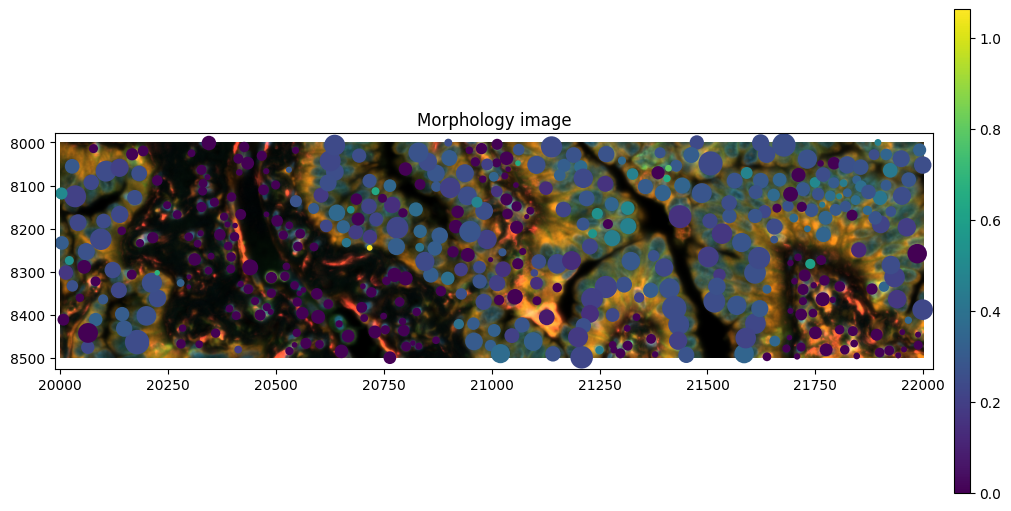

In [37]:
gene_name = "EPCAM"
crop0(sdata).pl.render_images("morphology_focus").pl.render_shapes(
    "cell_circles",
    color=gene_name,
).pl.show(title=f"{gene_name} expression over Morphology image", coordinate_systems="global", figsize=(10, 5))

We can also assign the table to a different region, in order to overlay the gene expression for the specified region.
SpatialData stores the information of which region is the table in the following places:
- in `sdata.tables[<table_name>].uns["spatialdata_attrs]["region"]` it stores the regions that the table is annotating.
- The name of the region is stored under `sdata.tables[<table_name>].obs["region_key"]`.

We can use a utility function to modify that information, and hence plot the gene expression for a different shapes.

/Users/giovanni.palla/miniconda3/envs/sdata310/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


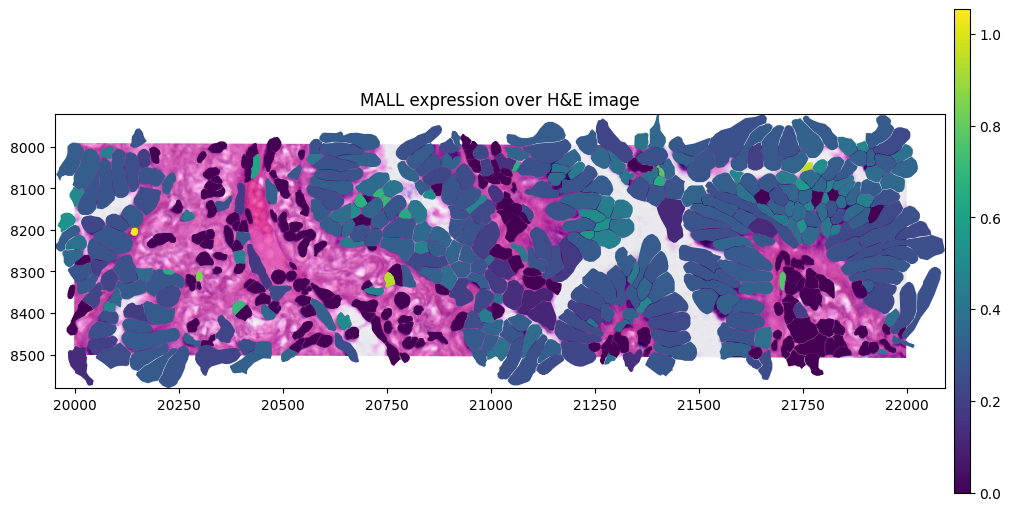

In [39]:
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

gene_name = "MALL"
crop0(sdata).pl.render_images("he_image").pl.render_shapes(
    "cell_boundaries",
    color=gene_name,
).pl.show(title=f"{gene_name} expression over H&E image", coordinate_systems="global", figsize=(10, 5))